In [52]:
#インポート

import pickle
from google.colab import files
from PIL import Image
import numpy as np
from scipy import signal
from sklearn.cluster import KMeans
import torch
import torch.nn as nn

In [53]:
#学習済みモデルの読み込み

#配色最適診断モデル
with open('/content/drive/MyDrive/アルバイト/PreApp/SVM_model.sav', mode='rb') as f:
    svm_model = pickle.load(f)

#上半身色生成モデル
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(3, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 3)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)

        return nn.Tanh()(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator_model = Generator()
generator_model.load_state_dict(torch.load('/content/drive/MyDrive/アルバイト/PreApp/generator_model.pth'))
generator_model.eval()

Generator(
  (fc1): Linear(in_features=3, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=3, bias=True)
  (activation): ReLU()
)

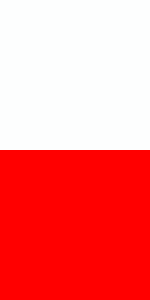

In [58]:
##上半身色生成のテスト

#上半身色のRGBを入力
lower_color = [255, 0, 0]

predict = generator_model(torch.tensor((np.array(lower_color) / 255),  dtype=torch.float32).to(device))
predict_rgb = np.array(predict.tolist()) * 255

color_img = np.zeros((300, 150, 3))
color_img[0:300, 0:150] = predict_rgb
color_img[150:300, 0:150] = lower_color


display(Image.fromarray(color_img.astype(np.uint8)))

In [38]:
#画像ファイルのアップロード

uploaded = files.upload()
file_name = next(iter(uploaded))

Saving test5.jpg to test5.jpg


In [39]:
#前処理

#画像の読み込み
img_color = Image.open("/content/" + file_name)
img_gray = img_color.convert("L") #グレースケール変換

#numpy配列に変換
img_color_np = np.asarray(img_color, dtype = "float32")
img_gray_np = np.asarray(img_gray, dtype = "float32")

#サイズを取得
img_h, img_w = img_gray_np.shape

In [40]:
#垂直方向の一次微分フィルタ

#カーネルを作成
kernel_v = np.zeros((3,3))
kernel_v[1,1] = -1
kernel_v[2,1] = 1

#畳み込み演算
img_v = signal.convolve2d(img_gray_np, kernel_v, mode="same")
img_v = np.clip(img_v, 0, 255).astype("uint8")

In [59]:
#上半身と下半身の境目を検出

ave_color = (np.average(img_v) + np.max(img_v)) / 2

line = np.where(img_v > ave_color)[0]

k = img_h // 100
count_list = []

for y in range(0, img_h, k):
    count_list.append(np.count_nonzero((line > y) & (y + k > line)))

count_list = list(map(lambda x: count_list.index(x) * k + (k // 2), count_list))

edge = count_list[np.abs(np.asarray(count_list) - (img_h / 2)).argmin()]

In [60]:
#色の量子化関数

def color_quantization(img, k):
    cluster = KMeans(n_clusters=k)
    cluster.fit(X=img)
    return cluster.cluster_centers_

In [61]:
#判定

kernel_size = 10

output = []
new_color_list = []

for y in range(0, img_h - edge, kernel_size):
    for x in range(img_w // 4, (img_w // 4) * 3, kernel_size):
        upper_body_main_color = color_quantization((img_color_np[y:y + kernel_size, x:x + kernel_size]).reshape(-1, 3), 5)
        lower_body_main_color = color_quantization((img_color_np[edge + y:edge + y + kernel_size, x:x + kernel_size]).reshape(-1, 3), 5)

        for i in range(len(upper_body_main_color)):
            input = np.concatenate([upper_body_main_color[i] / 255,lower_body_main_color[i] / 255])

            predict = svm_model.predict([input])[0]
            output.append(predict)

            new_color = generator_model(torch.tensor((lower_body_main_color[i] / 255),  dtype=torch.float32).to(device))
            new_color_list.append(np.array(new_color.tolist()) * 255)

output = np.array(output)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

この配色不適格（適格率：40.0%）です
下半身に使われている色に最適な上半身の色は次のとおりです。


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


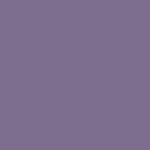

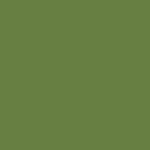

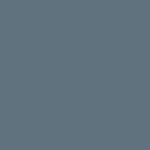

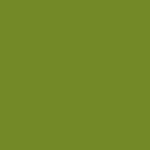

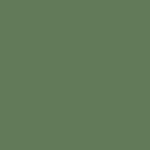

In [64]:
#結果を表示

ave = np.average(output)
judge = (ave >= 0.5).astype(int)

if judge == 1:
    print(f'この配色は適格（適格率：{ave * 100}%）です')
else:
    print(f'この配色不適格（適格率：{ave * 100}%）です')


print("下半身に使われている色に最適な上半身の色は次のとおりです。")

add_color = color_quantization(new_color_list, 5)

for i, color in enumerate(add_color):
    color_img = np.zeros((150, 150, 3))
    color_img[0:150, 0:150] = color

    display(Image.fromarray(color_img.astype(np.uint8)))
    print("\n")
